#LSTM 一維時序信號訓練及預測範例  
歐尼克斯實境互動工作室 OmniXRI Jack, 2021.6.15  
參考資料：Github lucko515/tesla-stocks-prediction  
https://github.com/lucko515/tesla-stocks-prediction

強迫Colab使用TensorFlow 1.x版以符合後續程式運行    
宣告必要使用函式庫  

In [1]:
%tensorflow_version 1.x
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline

print(tf.__version__) # 確認TensorFlow版本

TensorFlow 1.x selected.
1.15.2


#1.下載資料集並進行預處理
將資料集讀入並顯示開頭數筆完整資料  
只抽取'Close'一欄資料作為後續範例使用並顯示資料集筆數  

In [2]:
# 下載測試資料集  
# 使用 !wget https://raw.githubusercontent.com/lucko515/tesla-stocks-prediction/master/tesla_stocks.csv
# 取代 !wget https://github.com/lucko515/tesla-stocks-prediction/blob/master/tesla_stocks.csv

!wget -N https://raw.githubusercontent.com/lucko515/tesla-stocks-prediction/master/tesla_stocks.csv
!ls

# 列出資料集完整內容
#!cat tesla_stocks.csv

# 讀取完整資料集
tesla_stocks = pd.read_csv('tesla_stocks.csv')
# 顯示頭幾筆完整資料
tesla_stocks.head()

--2021-06-15 23:08:17--  https://raw.githubusercontent.com/lucko515/tesla-stocks-prediction/master/tesla_stocks.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34629 (34K) [text/plain]
Saving to: ‘tesla_stocks.csv’

tesla_stocks.csv    100%[===================>]  33.82K  --.-KB/s    in 0.001s  

Last-modified header missing -- time-stamps turned off.
2021-06-15 23:08:17 (27.8 MB/s) - ‘tesla_stocks.csv’ saved [34629/34629]

sample_data  tesla_stocks.csv


,Date,Open,High,Low,Close,Volume
0,2-Aug-17,318.94,327.12,311.22,325.89,13091462
1,1-Aug-17,323.00,324.45,316.13,319.57,8303102
2,31-Jul-17,335.50,341.49,321.04,323.47,8535136
3,28-Jul-17,336.89,339.60,332.51,335.07,4880414
4,27-Jul-17,346.00,347.50,326.29,334.46,8302405


In [3]:
# 只抽取'Close'欄位資料作為後續使用
data_to_use = tesla_stocks['Close'].values
# 列出資料集筆數
print('Total number of days in the dataset: {}'.format(len(data_to_use)))

Total number of days in the dataset: 756


#2.將資料正規化並繪製圖示

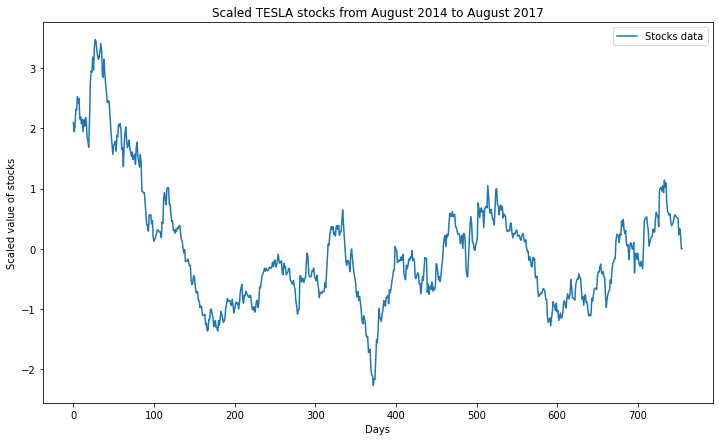

In [4]:
# 將資料正規化
scaler = StandardScaler()
scaled_dataset = scaler.fit_transform(data_to_use.reshape(-1, 1))
# 繪製原始資料
plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Scaled TESLA stocks from August 2014 to August 2017')
plt.xlabel('Days')
plt.ylabel('Scaled value of stocks')
plt.plot(scaled_dataset, label='Stocks data')
plt.legend()
plt.show()

#window_data()函式
以移動視窗方式提取輸入及輸出資料，以利後續訓練及驗證用。  

In [5]:
def window_data(data, window_size):
    X = [] # 取得輸入資料，window_size筆資料為一組
    y = [] # 取得輸出資料，window_size後的一筆
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) == len(y)
    return X, y

宣告程式所需主要參數

In [6]:
epochs = 200 # 訓練次數
batch_size = 7 # 資料批次提取數量
train_amount = 700 # 訓練資料數量

#3.取得訓練和測試資料集

In [7]:
# 取得訓練及測試資料
X, y = window_data(scaled_dataset, batch_size)
# 取得train_amount筆數資料作為訓練集
X_train  = np.array(X[:train_amount])
y_train = np.array(y[:train_amount])
# 剩下的部份作為測試集
X_test = np.array(X[train_amount:])
y_test = np.array(y[train_amount:])
# 列出資料集數量
print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (700, 7, 1)
y_train size: (700, 1)
X_test size: (49, 7, 1)
y_test size: (49, 1)


#LSTM_cell()函式  


In [8]:
def LSTM_cell(hidden_layer_size, batch_size,number_of_layers, dropout=True, dropout_rate=0.8):
    
    layer = tf.contrib.rnn.BasicLSTMCell(hidden_layer_size)
    
    if dropout:
        layer = tf.contrib.rnn.DropoutWrapper(layer, output_keep_prob=dropout_rate)
        
    cell = tf.contrib.rnn.MultiRNNCell([layer]*number_of_layers)
    
    init_state = cell.zero_state(batch_size, tf.float32)
    
    return cell, init_state

#output_layer()函式  

In [9]:
def output_layer(lstm_output, in_size, out_size):
    
    x = lstm_output[:, -1, :]
    print(x)
    weights = tf.Variable(tf.truncated_normal([in_size, out_size], stddev=0.05), name='output_layer_weights')
    bias = tf.Variable(tf.zeros([out_size]), name='output_layer_bias')
    
    output = tf.matmul(x, weights) + bias
    return output

#opt_loss()函式

In [10]:
def opt_loss(logits, targets, learning_rate, grad_clip_margin):
    
    losses = []
    for i in range(targets.get_shape()[0]):
        losses.append([(tf.pow(logits[i] - targets[i], 2))])
        
    loss = tf.reduce_sum(losses)/(2*batch_size)
    
    #Cliping the gradient loss
    gradients = tf.gradients(loss, tf.trainable_variables())
    clipper_, _ = tf.clip_by_global_norm(gradients, grad_clip_margin)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))
    return loss, train_optimizer

#StockPredictionRNN()類別函式


In [11]:
class StockPredictionRNN(object):
    
    def __init__(self, learning_rate=0.001, batch_size=7, hidden_layer_size=512, number_of_layers=1, 
                 dropout=True, dropout_rate=0.8, number_of_classes=1, gradient_clip_margin=4, window_size=7):
    
        self.inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1], name='input_data')
        self.targets = tf.placeholder(tf.float32, [batch_size, 1], name='targets')

        cell, init_state = LSTM_cell(hidden_layer_size, batch_size, number_of_layers, dropout, dropout_rate)

        outputs, states = tf.nn.dynamic_rnn(cell, self.inputs, initial_state=init_state)

        self.logits = output_layer(outputs, hidden_layer_size, number_of_classes)

        self.loss, self.opt = opt_loss(self.logits, self.targets, learning_rate, gradient_clip_margin)

設定model, session

In [12]:
tf.reset_default_graph()
model = StockPredictionRNN()

session =  tf.Session()
session.run(tf.global_variables_initializer())

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Tensor("strided_slice:0", shape=(7, 512), dtype=float32)
Instructions for updating:


#開始訓練

In [13]:
import time

time_start = time.time() #開始計時

for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]
        
        o, c, _ = session.run([model.logits, model.loss, model.opt], feed_dict={model.inputs:X_batch, model.targets:y_batch})
        
        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 10) == 0: # 每隔10次列出目前損失率，次數可自行調整
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

time_end = time.time() # 結束計時
time_c= time_end - time_start # 計算執行所花時間
print('time cost', time_c, 's') # 列出總共花費時間

Epoch 0/200  Current loss: 0.1312003880739212
Epoch 10/200  Current loss: 0.03576570376753807
Epoch 20/200  Current loss: 0.015247025527060032
Epoch 30/200  Current loss: 0.014600357040762901
Epoch 40/200  Current loss: 0.01514343824237585
Epoch 50/200  Current loss: 0.013507753610610962
Epoch 60/200  Current loss: 0.012696965597569942
Epoch 70/200  Current loss: 0.013306337408721447
Epoch 80/200  Current loss: 0.01209886185824871
Epoch 90/200  Current loss: 0.013038009405136108
Epoch 100/200  Current loss: 0.013008605688810349
Epoch 110/200  Current loss: 0.012613953091204166
Epoch 120/200  Current loss: 0.012381779961287975
Epoch 130/200  Current loss: 0.012589936144649982
Epoch 140/200  Current loss: 0.011886936612427235
Epoch 150/200  Current loss: 0.012241095304489136
Epoch 160/200  Current loss: 0.01134408824145794
Epoch 170/200  Current loss: 0.012960926629602909
Epoch 180/200  Current loss: 0.011439875699579716
Epoch 190/200  Current loss: 0.012724042870104313
time cost 139.192

取得正規化後原始資料

In [14]:
sup =[]
for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
        sup.append(traind_scores[i][j])

取得測試資料

In [15]:
tests = []
i = 0
while i+batch_size <= len(X_test):
    
    o = session.run([model.logits], feed_dict={model.inputs:X_test[i:i+batch_size]})
    i += batch_size
    tests.append(o)

產生最後測試資料

In [16]:
tests_new = []
for i in range(len(tests)):
    for j in range(len(tests[i][0])):
        tests_new.append(tests[i][0][j])

分別產生訓練和測試結果資料序列

In [17]:
test_results = []
for i in range(749):
    if i >= 701:
        test_results.append(tests_new[i-701])
    else:
        test_results.append(None)

#繪製出結果
藍色線為原始資料正規化內容，橙色線訓練集資料，綠色為測試輸出結果。

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


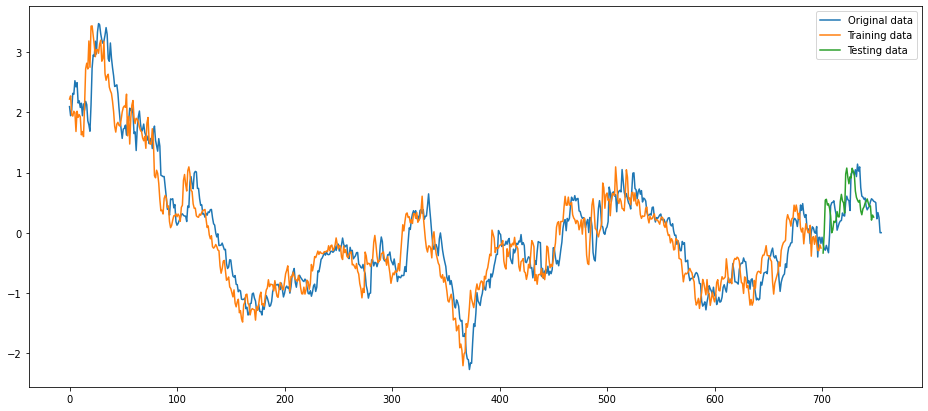

In [18]:
plt.figure(figsize=(16, 7))
plt.plot(scaled_dataset, label='Original data')
plt.plot(sup, label='Training data')
plt.plot(test_results, label='Testing data')
plt.legend()
plt.show()

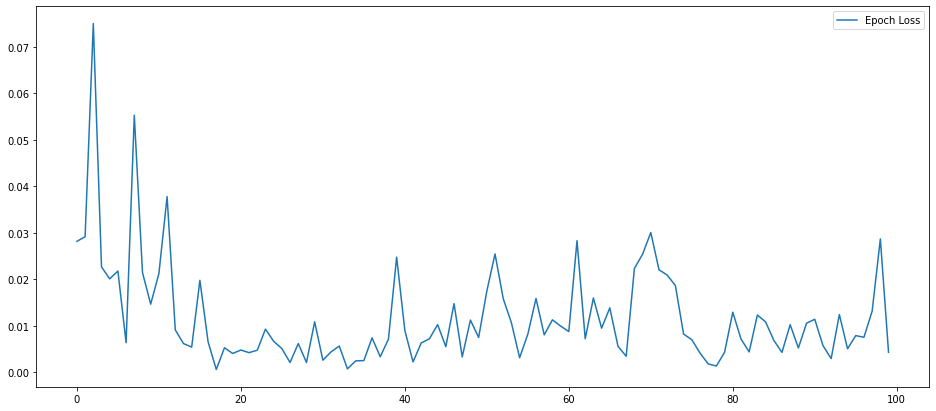

In [19]:
plt.figure(figsize=(16, 7))
plt.plot(epoch_loss, label='Epoch Loss')
plt.legend()
plt.show()

In [20]:
session.close()